In [1]:
from Models.MainModel import InitModel
from Config import Config
from Utils.Visualization import ShowOcclusionSensitivity
from Utils.FileOperation import ls

import random
import torch
from PIL import Image
import cv2

In [2]:
random.seed(42)

In [3]:
config = Config()
config.apply()

In [4]:
no_leaky_config = Config()
no_leaky_config.model.leaky = 0
no_leaky_config.apply()

In [5]:
checkpoint_paths = [
    ('Checkpoints/_GridSearch/WDF_W4_D32/checkpoint_25.pth', config),
    ('Checkpoints/_Ablation/NoGaze/checkpoint_25.pth', config),
]
transform = config.test.transform['standard']
data_paths = []
for s in ['fake_test', 'real_test']:
    data_root = config.basic.rootDir + 'clipped_videos/WDF_clip/' + s + '/'
    current_files = ls(data_root)
    random.shuffle(current_files)
    for i in range(len(current_files)):
        data_paths.append(data_root + current_files[i])
    random.shuffle(data_paths)

In [6]:
def model_prep():
    global model
    model = InitModel(current_config)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])

    model.eval()
    model.cuda()
    

def input_prep():
    global input_tensor
    # Load video frames from data_path to `frames` using cv2
    vidcap = cv2.VideoCapture(data_path)
    frames = []
    for i in range(14):
        success, frame = vidcap.read()
        frames.append(frame)
    vidcap.release()
    input_tensor = torch.FloatTensor(14, 3, 224, 224)
    for i in range(14):
        input_tensor[i] = transform(Image.fromarray(frames[i]))
    input_tensor = torch.unsqueeze(input_tensor, 0).cuda()

In [ ]:
eval_type = {
    'TP': [],
    'TN': [],
    'FP': [],
    'FN': [],
}
collect_types = ['TN', 'TP', 'FN', 'FP']
amt_per_type = 10
for data_path in data_paths:
    
    print(data_path)
    
    ground_truth_label = 1
    if 'fake' in data_path or 'synthesis' in data_path:
        ground_truth_label = 0
    
    temp_set = []
    eval_results = [None, None]
    for i, (checkpoint_path, current_config) in enumerate(checkpoint_paths):
        model, input_tensor = None, None
        model_prep()
        input_prep()
        
        # Get Result
        prediction = model(input_tensor)
        input_tensor = input_tensor.detach().cpu()
        del input_tensor
        print(prediction[0])
        predicted_label = int(prediction[0].argmax())
        
        if predicted_label == 1 and ground_truth_label == 1 and len(eval_type['TP']) < amt_per_type:
            eval_results[i] = 'TP'
        elif predicted_label == 0 and ground_truth_label == 0 and len(eval_type['TN']) < amt_per_type:
            eval_results[i] = 'TN'
        elif predicted_label == 1 and ground_truth_label == 0 and len(eval_type['FP']) < amt_per_type:
            eval_results[i] = 'FP'
        elif predicted_label == 0 and ground_truth_label == 1 and len(eval_type['FN']) < amt_per_type:
            eval_results[i] = 'FN'
        if eval_results[i] is None:
            break
        
        model = model.cpu()
        del model
    
    if eval_results[0] != eval_results[1] or eval_results[0] is None or eval_results[0] not in collect_types:
        print('Skip')
        continue
    
    for i, (checkpoint_path, current_config) in enumerate(checkpoint_paths):
        model = None
        model_prep()
        
        final_img, heatmap = ShowOcclusionSensitivity(model, data_path, transform, cube_size=32, step=8, batch_size=16, oneImg=False)
        temp_set.append([final_img, heatmap])
        
        model = model.cpu()
        del model
        
    eval_type[eval_results[0]].append([data_path, temp_set])
    
    print(len(eval_type['TP']), len(eval_type['FP']), len(eval_type['TN']), len(eval_type['FN']))
    
    if len(eval_type['TP']) + len(eval_type['FP']) + len(eval_type['TN']) + len(eval_type['FN']) == amt_per_type*len(collect_types):
        print('Finished')
        break

/home/kyr/GazeForensicsData/clipped_videos/WDF_clip/fake_test/fake_test_49_93_4.mp4
Initializing base model
tensor([9.9141e-04, 9.9901e-01], device='cuda:0', grad_fn=<SelectBackward0>)
Initializing base model
tensor([0.8592, 0.1408], device='cuda:0', grad_fn=<SelectBackward0>)
Skip
/home/kyr/GazeForensicsData/clipped_videos/WDF_clip/fake_test/fake_test_88_0_32.mp4
Initializing base model
tensor([2.7882e-04, 9.9972e-01], device='cuda:0', grad_fn=<SelectBackward0>)
Initializing base model
tensor([0.9751, 0.0249], device='cuda:0', grad_fn=<SelectBackward0>)
Skip
/home/kyr/GazeForensicsData/clipped_videos/WDF_clip/fake_test/fake_test_13_0_142.mp4
Initializing base model
tensor([0.9814, 0.0186], device='cuda:0', grad_fn=<SelectBackward0>)
Initializing base model
tensor([9.9910e-01, 9.0360e-04], device='cuda:0', grad_fn=<SelectBackward0>)
Initializing base model
 > Prediction: [0.98139465 0.01860532]


In [8]:
torch.save(eval_type, 'Results/WDF_OccSensitivity.pkl')

In [9]:
eval_type = torch.load('Results/WDF_OccSensitivity.pkl')

TP :


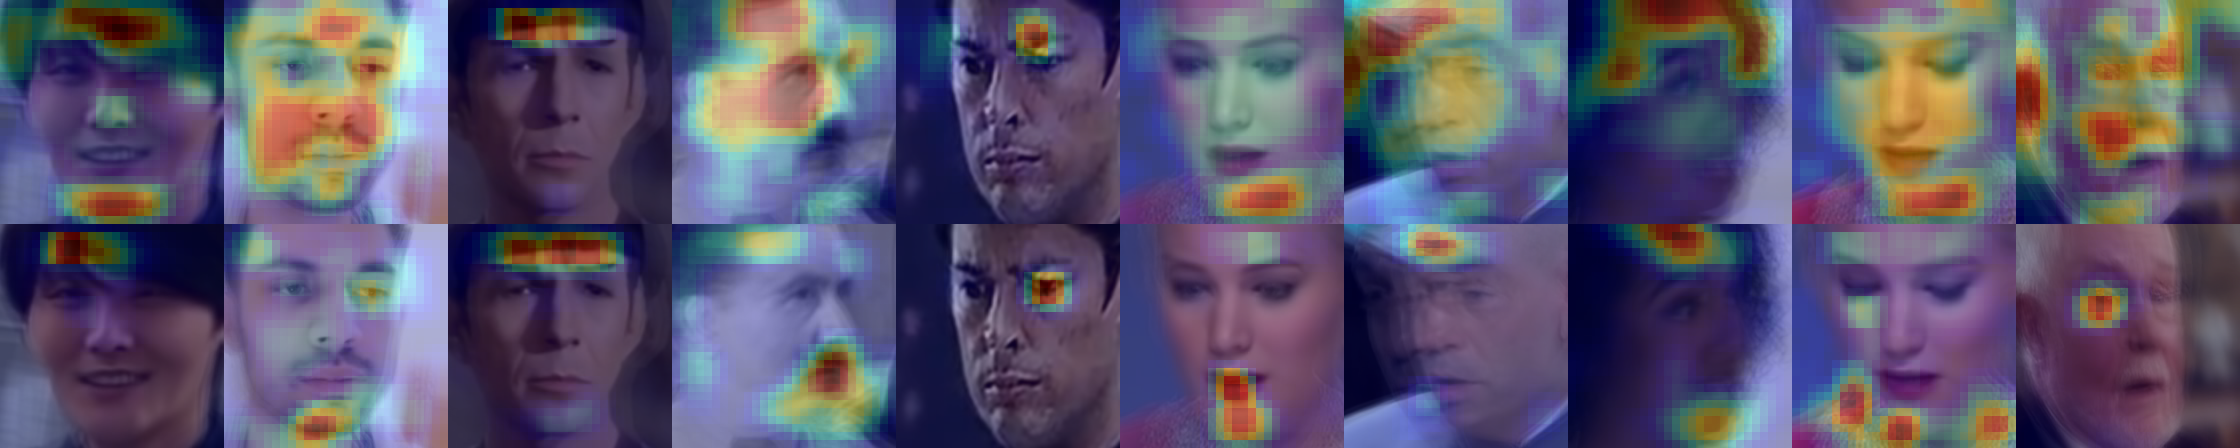

TN :


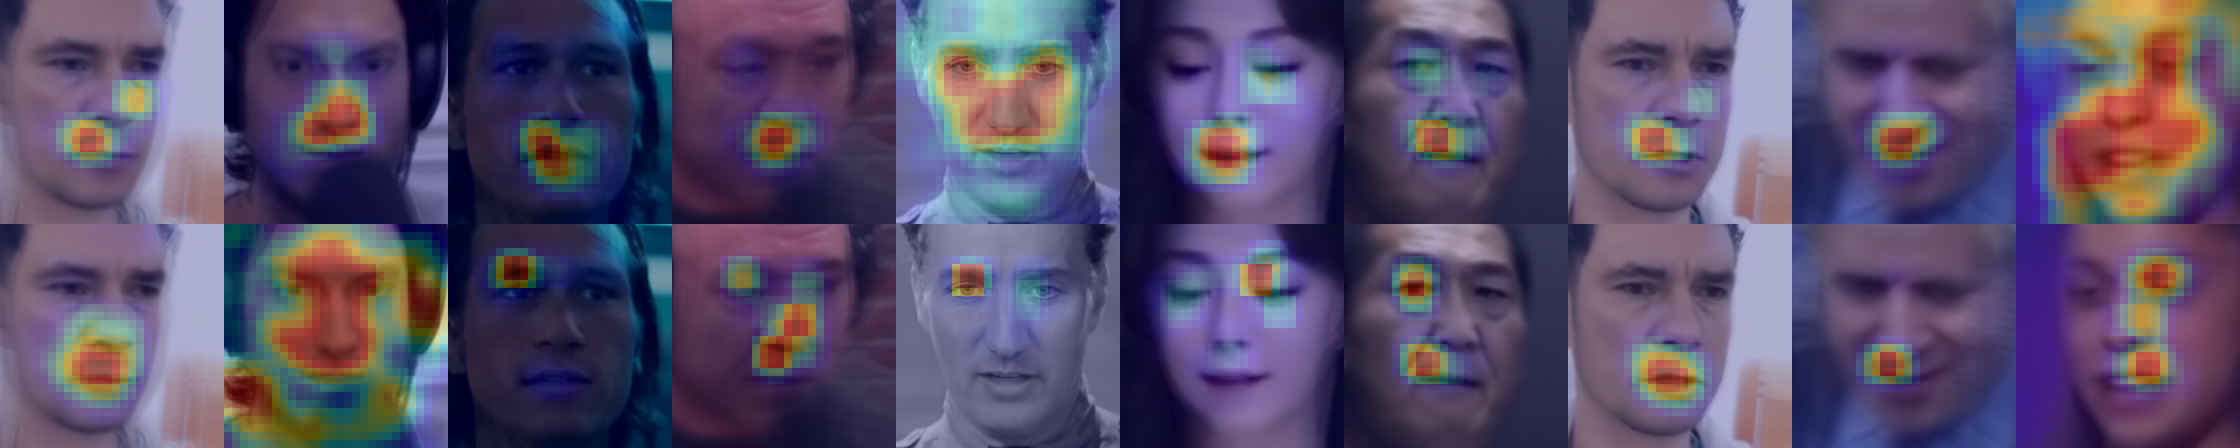

FP :


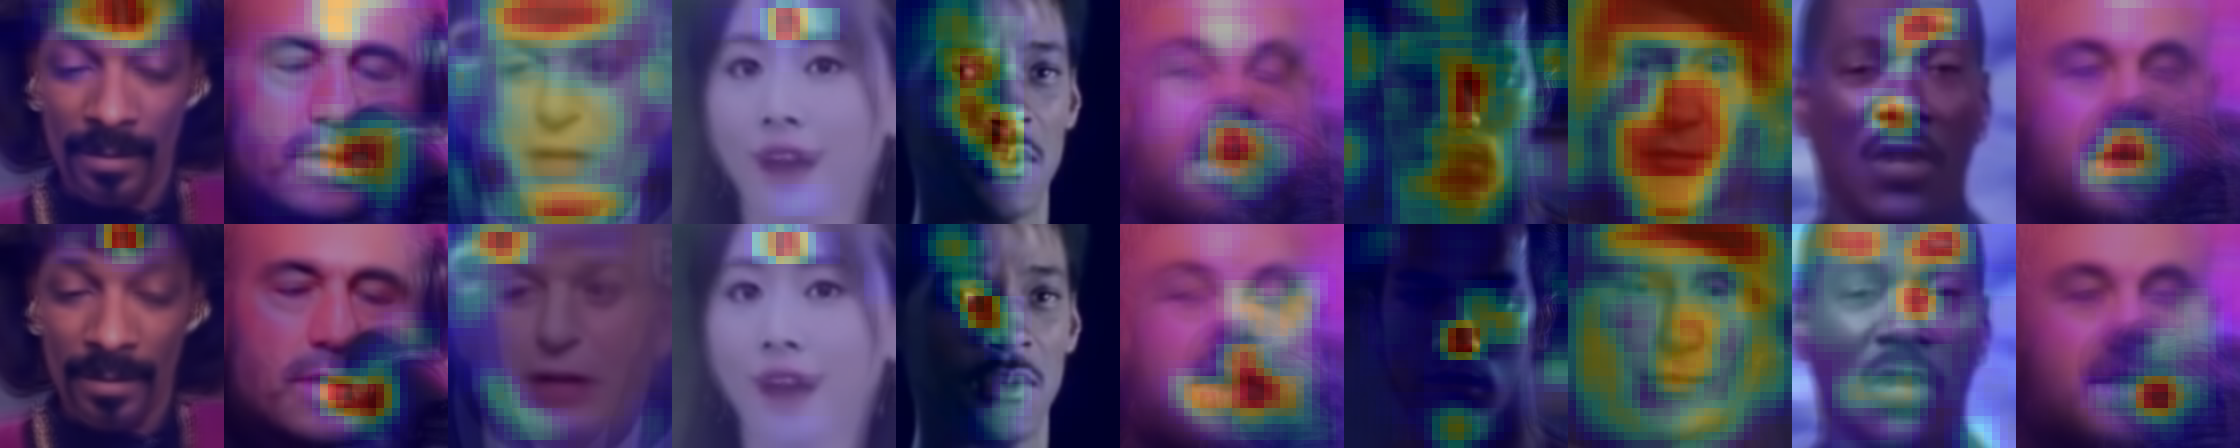

FN :


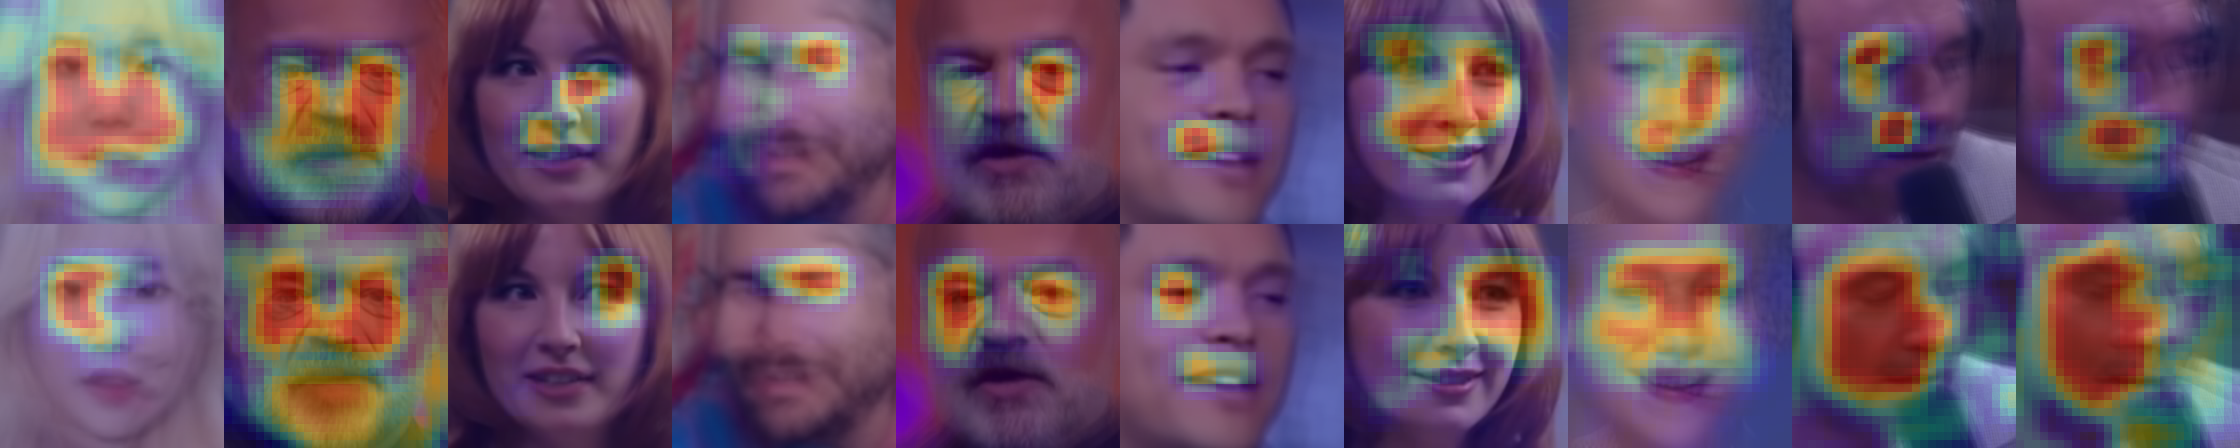

In [10]:
for key in eval_type.keys():
    if len(eval_type[key]) == 0:
        continue
    print(key, ':')
    concatenated_image = Image.new('RGB', (224*10, 224*2))
    for i in range(len(eval_type[key])):
        concatenated_image.paste(eval_type[key][i][1][0][0], (224*i, 0))
        concatenated_image.paste(eval_type[key][i][1][1][0], (224*i, 224))
    concatenated_image.show()